In [21]:
import pandas as pd
import numpy as np
import pymysql
from datetime import datetime, timedelta
from sqlalchemy import create_engine
import re
import os
from functools import reduce
pd.options.mode.chained_assignment = None  # default='warn'

In [22]:
import math
import matplotlib.pyplot as plt
import datetime as dt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from tensorflow import keras

### Loading Data From Database(local MySQL)

In [23]:
username = 'root'
password = pwd
host_port = 'localhost:3306' 
database = 'twfruits'

engine = create_engine("mysql+pymysql://{}:{}@{}/{}".format(username, password, host_port, database))
con = engine.connect()

In [24]:
# test

fruit = "banana"
market = "台北二"
df_test = pd.read_sql(f"{fruit}_{market}", engine)
df_test.tail()

,日期,banana_平均價,banana_交易量,scarletbanana_平均價,guava_平均價,banana_前日平均價,banana_5日平均價
3868,2021-08-04,37.9,5550.0,35.2,31.4,35.2,37.7
3869,2021-08-05,40.7,5530.0,38.0,29.3,37.9,38.3
3870,2021-08-06,38.3,5891.0,38.6,32.9,40.7,38.0
3871,2021-08-07,46.1,4681.0,42.3,29.9,38.3,39.6
3872,2021-08-08,47.5,4485.0,40.4,48.4,46.1,42.1


### 從SQL取資料進行模型訓練 => 完成後存成h5檔(共8個)

In [25]:
from my_model_trainer import *

Ongoing: guava_台北二==========================================================================================
X's shape: (3063, 30, 6)
y's shape: (3063, 7)
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 30, 64)            18176     
_________________________________________________________________
lstm_35 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 231       
Total params: 30,823
Trainable params: 30,823
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
22/22 [==============================] - 7s 72ms/step - loss: 0.7723 - val_loss: 

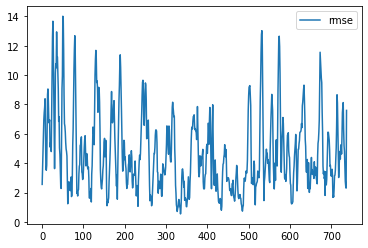

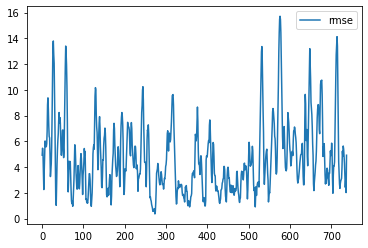

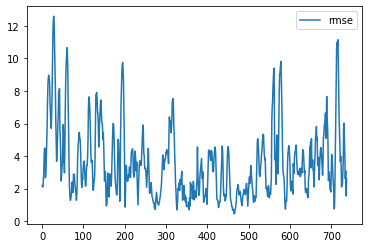

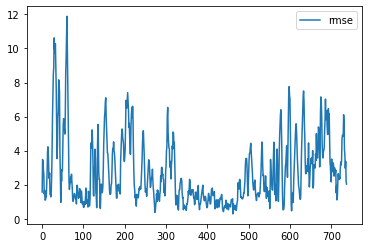

In [48]:
fruits = {"banana": ["banana", "scarletbanana", "guava"],
          #"guava":  ["guava", 'emperorguava', 'banana']}

markets = ['台北二', '台北一', '三重區', '台中市']

pred_list = []
actual_list = []
# 參數設定
n_future = 7
n_past = 30
epochs = 30
batch_size = 128


for Fruit, Type in fruits.items():
    for market in markets:
        print(f"Ongoing: {Fruit}_{market}" + "==="*30)
        
        # 讀取分析資料
        df_merged = pd.read_sql(f"{Fruit}_{market}", engine)
    
        # 訓練集、測試集
        train_set, test_set = train_test_split(df_merged)

        ### 訓練集part
        # 訓練集(sc)、訓練集預測(scaler)
        train_set_sc, sc_train_target = data_normalization(train_set)

        # 訓練集
        X_train, y_train = split_Xy(train_set_sc, n_future=n_future, n_past=n_past)

        # 創造momdel
        model = model_creator(n_past=X_train.shape[1], n_features=X_train.shape[2], output=y_train.shape[1])

        # 訓練model
        trained_model = model_trainer(model, X_train, y_train, epoch=epochs, batch_size=batch_size)

        # 訓練集驗證
        # prediction_train, actual_train = model_validation(trained_model, X_train, y_train, sc_train_target)

        ### 測試集part
        # 測試集(sc)、測試集預測(scaler)
        test_set_sc, sc_test_target = data_normalization(test_set)

        # 測試集、test_scaler
        X_test, y_test = split_Xy(test_set_sc, n_future=n_future, n_past=n_past)

        # 測試集驗證
        prediction_test, actual_test = model_validation(trained_model, X_test, y_test, sc_test_target)
        
        pred_list.append(prediction_test)
        actual_list.append(actual_test)
        
        
        # 儲存模型
        #trained_model.save(f"C:/Users/Tibame/PycharmProjects/PythonETL/Fruit Price Prediction/models/{Fruit}_Price/{market}.h5")
        

### Visualization

IndexError: list index out of range

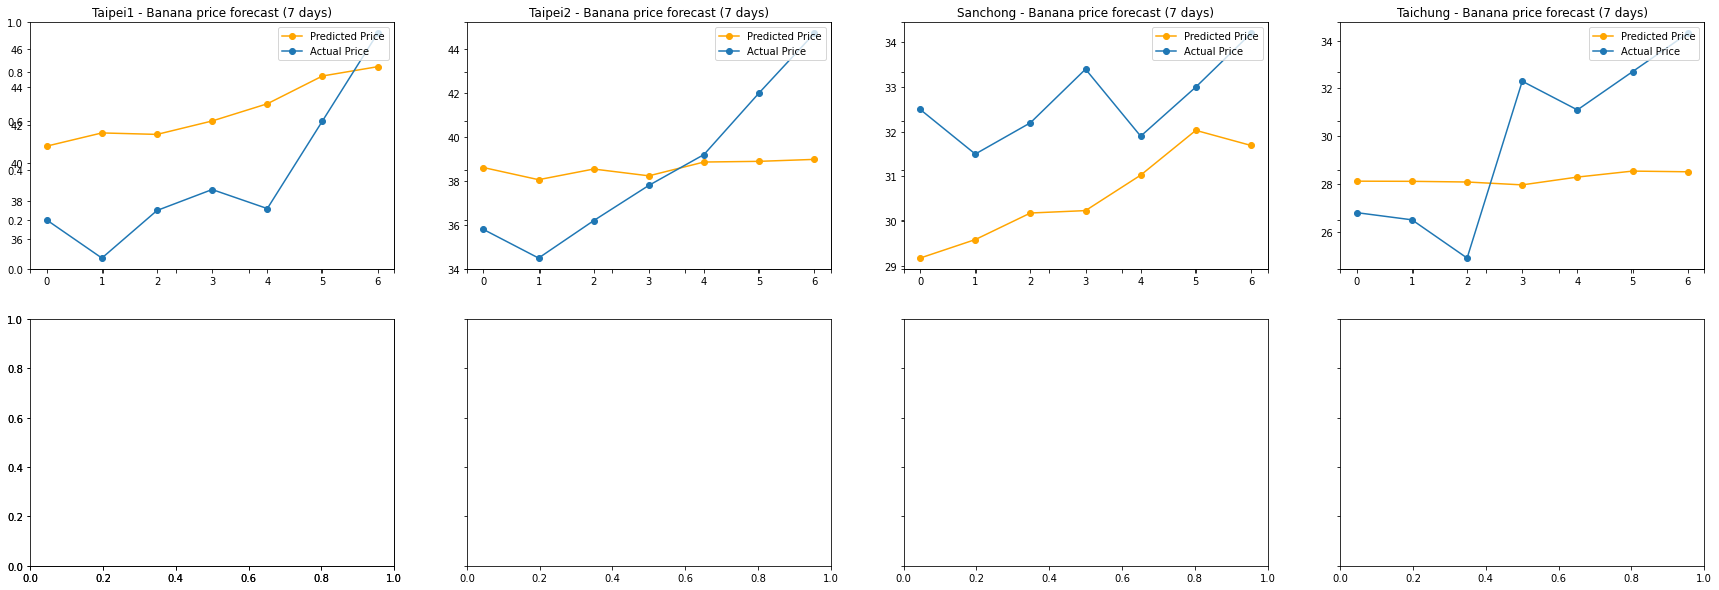

In [50]:
# fig, axes = plt.subplots(2, 4, figsize=(30,10), sharex=True, sharey=True) #, squeeze=True)

# #     ax.xaxis.set_major_locator(plt.NullLocator())
# #     ax.yaxis.set_major_locator(plt.NullLocator())

# markets = ["Taipei1", "Taipei2", "Sanchong", "Taichung"]
# fruits = ["Banana", "Guava"]

# n = 200

# for i in list(range(8)):
#     ax = fig.add_subplot(2, 4, i+1)
#     ax.plot(np.arange(30), pred_list[i][n], label="Predicted Price", color="orange")
#     ax.plot(np.arange(30), actual_list[i][n], label="Actual Price")
#     ax.set_xticks(np.arange(0, 31, 5))
#     if i <= 4:
#         fruit = fruits[0]
#     else:
#         fruit = fruits[1]
        
#     ax.set_title(f"1-month price {fruit} forecasts for {markets[i%4]} Market")
#     #ax.set_yticks(np.arange(0, 50, 10))
    
#     ax.legend(loc="upper right")

fig, axes = plt.subplots(2, 4, figsize=(30,10), sharex=True, sharey=True) #, squeeze=True)

#     ax.xaxis.set_major_locator(plt.NullLocator())
#     ax.yaxis.set_major_locator(plt.NullLocator())

markets = ["Taipei1", "Taipei2", "Sanchong", "Taichung"]
fruits = ["Banana", "Guava",]

n = 7
index = 200 # 200

for i in list(range(8)):
    ax = fig.add_subplot(2, 4, i+1)
    ax.plot(np.arange(n), pred_list[i][index][:n], label="Predicted Price", color="orange", marker="o")
    ax.plot(np.arange(n), actual_list[i][index][:n], label="Actual Price", marker="o")
    #ax.set_xticks(np.arange(0, 31, 5))
    if i <= 4:
        fruit = fruits[0]
    else:
        fruit = fruits[1]
        
    ax.set_title(f"{markets[i%4]} - {fruit} price forecast (7 days)")
    #ax.set_yticks(np.arange(0, 50, 10))
    
    ax.legend(loc="upper right")
    

### 預測結果評估(rmse, mape, mad)
- mape : 平均絕對百分比誤差(Mean absolute percentage error)
- rmse : 均方根差(root-mean-square error)
- mad : 平均絕對偏差（Mean Absolute Deviation)

In [39]:
# mean_absolute_percentage_error => sklearn版本問題無法import
from sklearn.metrics import mean_squared_error

In [40]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [41]:
def mad(y_true, y_pred):
    return sum(np.abs((y_true - y_pred) / len(y_true)))

In [44]:
rmse_output = []
mape_output = []
mad_output = []

n = 200

for i in list(range(8)):
    rmse_output.append(round(mean_squared_error(pred_list[i][n], actual_list[i][n], squared=False), 2))
    mape_output.append(round(mape(actual_list[i][n], pred_list[i][n]),2))
    mad_output.append(round(mad(actual_list[i][n], pred_list[i][n]),2))

indexs = ['Banana_Taipei1', 'Banana_Taipei2', 'Banana_Sanchong', 'Banana_Taichung',
        'Guava_Taipei1', 'Guava_Taipei2', 'Guava_Sanchong','Guava_Taichung']

df_result_evaluation = pd.DataFrame({"RMSE" : rmse_output,
                                     "MAPE" : mape_output,
                                     "MAD" : mad_output}, index= indexs)

df_result_evaluation

,RMSE,MAPE,MAD
Banana_Taipei1,2.81,6.00,2.38
Banana_Taipei2,2.51,5.70,1.95
Banana_Sanchong,6.70,16.98,6.53
Banana_Taichung,2.07,4.77,1.68
Guava_Taipei1,8.52,31.72,6.66
Guava_Taipei2,7.12,29.18,5.88
Guava_Sanchong,7.34,36.46,6.61
Guava_Taichung,4.82,22.41,3.99


### 從SQL取分析資料進行價格預測
- 直接透過query取得資料進行分析
- 預測結果存入DB

In [126]:
fruits = {"banana": ["banana", "scarletbanana", "guava"],
          "guava":  ["guava", 'emperorguava', 'banana']}

markets = ['台北二', '台北一', '三重區', '台中市']

pred_output = []
actual_output = []

# date
tmr = (datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')
future_dates = list(pd.date_range(start=tmr, freq="d", periods=7))

# sql schema
df_for_sql = pd.DataFrame(columns=["水果","市場", "日期", "價格"])

# prediction
for Fruit, Type in fruits.items():
    for market in markets:
        
        product = Type[0]
        same = Type[1]
        sub = Type[2]
        
        # 從SQL讀取分析資料，轉換成矩陣
        df_set = pd.read_sql_query(f"""select `{product}_平均價`, `{product}_交易量`, `{same}_平均價`, 
                                       `{sub}_平均價`, `{product}_前日平均價`, `{product}_5日平均價` 
                                       from {product}_{market}
                                       order by `日期` desc
                                       limit 30""", con).values 
        
        # 標準化
        df_set_sc, sc_target = data_normalization(df_set)
        
        # reshape => 需符合input的shape
        df_set_sc = df_set_sc.reshape(-1, 30, 6)
        
        # 載入model
        model_loaded = keras.models.load_model(f"models/{product}_Price/{market}.h5")
        
        # 進行預測
        pred_result = model_loaded(df_set_sc)                                                                          # 使用model_loaded.predict(df_set_sc)會跳出tensorflow warning
        
        # 透過inverse_transform還原為原本數值
        output = sc_target.inverse_transform(pred_result).reshape(-1).round(2)
        
        for date, price in zip(future_dates, output):
            df_for_sql = df_for_sql.append({"水果":Fruit, "市場":market, "日期":date, "價格":price}, ignore_index=True)
                                           
        print(f"{Fruit}_{market}市場未來7日預測價: ", output)


banana_台北二市場未來7日預測價:  [33.85 34.33 34.61 33.75 34.16 34.53 34.29]
banana_台北一市場未來7日預測價:  [27.49 27.35 27.52 27.37 27.69 27.53 27.64]
banana_三重區市場未來7日預測價:  [29.55 29.33 29.47 29.07 29.81 29.86 29.33]
banana_台中市市場未來7日預測價:  [30.44 30.46 30.35 30.46 30.4  30.58 30.53]
guava_台北二市場未來7日預測價:  [34.33 33.99 33.98 33.98 34.5  34.31 34.69]
guava_台北一市場未來7日預測價:  [33.37 33.77 33.14 33.76 33.75 33.57 33.69]
guava_三重區市場未來7日預測價:  [27.93 27.84 27.86 27.89 28.42 28.09 28.1 ]
guava_台中市市場未來7日預測價:  [28.88 29.81 30.42 30.55 30.2  29.96 30.25]


In [131]:
df_for_sql["價格"] = df_for_sql["價格"].apply(lambda x:round(x,2))

In [130]:
# 預測結果寫入MySQL中
df_for_sql.to_sql(name='predicted price', 
                  con=con, if_exists='append', index=False)